In [1]:
%matplotlib
# %%
import gc
import gzip
import pickle
from datetime import datetime
from glob import glob

import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
from matplotlib import cm
from scipy.signal import (
    correlate,
    cspline1d,
    find_peaks,
    cwt,
    ricker,
    medfilt,
    morlet2,
    sepfir2d,
)
from tqdm import trange

# warnings.filterwarnings("error")

def smooth_and_norm_real(vals, winsize=95, smoothing=0.2, zcutoff=3.0):
    win = np.ones((winsize,))
    win_count = correlate(np.ones_like(vals), win)
    signal = np.copy(vals)
    init_rms = np.sqrt(correlate(np.square(signal), win) / win_count)
    init_cond = np.where(
        init_rms[: 1 - winsize] < init_rms[winsize - 1 :],
        init_rms[: 1 - winsize],
        init_rms[winsize - 1 :],
    )
    for _ in range(8):
        moving_rms = np.sqrt(correlate(np.square(signal), win) / win_count)
        min_rms = np.minimum(moving_rms[: 1 - winsize], moving_rms[winsize - 1 :]).clip(
            1e-5
        )
        magclip = (
            zcutoff * min_rms / np.maximum(min_rms * zcutoff, np.abs(signal)).clip(1e-5)
        )
        signal *= magclip
    moving_avg = correlate(signal / min_rms, win) / win_count
    min_avg = np.where(
        init_cond,
        moving_avg[: 1 - winsize],
        moving_avg[winsize - 1 :],
    )
    min_avg = moving_avg[winsize // 2 : -(winsize // 2)]

    smoothed = cspline1d(signal / min_rms - min_avg, lamb=smoothing)

    return smoothed, vals / min_rms - min_avg


def compute_r2(data, fit, winsize=255):
    hw = winsize // 2
    win = np.ones((winsize,))
    err = data - fit
    avgs = correlate(data, win, mode="same") / winsize
    sum_err2 = correlate(np.square(err), win, mode="same")
    idx = np.arange(data.shape[0])[:, None] + np.arange(winsize)
    data_ext = np.concatenate((np.zeros(hw), data, np.zeros(hw)), axis=0)
    sum_var = np.sum(np.square(data_ext[idx] - avgs[:, None]), axis=1)
    sum_var = np.var(data_ext[idx] - avgs[:, None], axis=1) * winsize
    r2 = 1 - sum_err2 / sum_var

    return r2, err, sum_err2, sum_var


def get_findiff_curvature(data):
    curvature = np.zeros_like(data)
    curvature[1:-1] = data[:-2] + data[2:] - 2.0 * data[1:-1]
    curvature[0] = curvature[1]
    curvature[-1] = curvature[-2]
    return curvature


def morlet_real(*args, **kwargs):
    return np.real(morlet2(*args, **kwargs))


def get_slopes(data):
    dx = data[:, 1:] - data[:, :-1]  # x right
    dy = data[1:] - data[:-1]  # y down
    de = data[1:, 1:] - data[:-1, :-1]  # y down, x right
    do = data[1:, :-1] - data[:-1, 1:]  # y down, x left

    tl = de[:-1, :-1]
    tc = dy[:-1, 1:-1]
    tr = do[:-1, 1:]
    rc = -dx[1:-1, 1:]
    br = -de[1:, 1:]
    bc = -dy[1:, 1:-1]
    bl = -do[1:, :-1]
    lc = dx[1:-1, :-1]

    res = np.zeros((8, data.shape[0], data.shape[1]))
    res[:, 1:-1, 1:-1] = np.stack((tl, tc, tr, rc, br, bc, bl, lc), axis=0)
    return res


def wavefinding_cwt(signal, widths, omega=5):
    output = np.empty((len(widths), len(signal)), dtype=np.complex128)
    for ind, width in enumerate(widths):
        # go for an odd window length about 8x the length of the width
        N = round(4 * width - 0.5) * 2 + 1
        N = np.min([N, len(signal)])
        wavelet_data = morlet2(N, width, omega)
        # using correlate instead of convolve
        output[ind] = correlate(
            signal.astype(np.complex128), wavelet_data, mode="same"
        ) * np.exp(-1.0j * omega * np.arange(len(signal)) / width)
    return output


def flip_signal(signal):
    smoothed, normed = smooth_and_norm_real(signal, smoothing=20.0)

    r2, *_ = compute_r2(normed.clip(-3.0, 3.0), smoothed, winsize=255)

    curv = get_findiff_curvature(smoothed)

    bmp = 21 / 60  # max breaths per second
    fs = 5  # sample rate
    max_curv_exag = (2 * np.pi * bmp / fs) ** 4

    curv_exag = (curv * np.abs(curv)) / max_curv_exag

    curv_exag_sm = correlate(curv_exag, np.ones(1001) / 10.0, mode="same")

    past_3 = np.argwhere(np.abs(normed) > 5.0).squeeze()
    num_outliers = len(past_3)
    outliers = np.zeros(num_outliers + 2, dtype=int)
    outliers[1:-1] = past_3
    outliers[-1] = len(signal) - 1

    righted = np.zeros_like(signal)
    stdev = 20.0
    windows = np.zeros_like(signal)

    for idx in range(num_outliers + 1):
        start = outliers[idx]
        stop = outliers[idx + 1]

        win_range = np.minimum(np.arange(stop - start), np.arange(stop - start)[::-1])
        window = 1.0 - np.exp(-0.5 * np.square(win_range.clip(max=3 * stdev) / stdev))
        windows[start:stop] = window

        right = np.sum(curv_exag[start:stop] * window) <= 0.0

        if right:
            righted[start:stop] = normed[start:stop]
        else:
            righted[start:stop] = -normed[start:stop]

    # _, ax = plt.subplots(1, 1)
    # ax.plot(normed)
    # ax.plot(smoothed)
    # ax.plot(windows)
    # ax.plot(righted, linestyle="--")
    # ax.plot(curv_exag)
    # ax.plot(curv_exag_sm)
    # ax.plot(r2)
    # ax.legend(["norm", "sm", "win", "right", "curv", "curvsm", "r2"])
    # plt.show()

    return smoothed, normed, r2, righted, curv_exag


def flip_components_indiv_and_combine(real, imag):
    """Normalizes the traces, then compares them and weights the wavier one higher."""
    real_smooth, real_norm, real_r2, real_righted, real_curv = flip_signal(real)
    imag_smooth, imag_norm, imag_r2, imag_righted, imag_curv = flip_signal(imag)

    omega = 20.0
    fs = 5.0
    freqs = np.logspace(0.1, -1.4, 150)  # ~50-85 are breathing frequencies
    widths_morlet = omega * fs / (freqs[55:80] * 2 * np.pi)
    real_wave = wavefinding_cwt(real_righted.clip(-3.0, 3.0), widths_morlet, omega)
    mags_real = np.sum(np.square(np.abs(real_wave)), axis=0)
    imag_wave = wavefinding_cwt(imag_righted.clip(-3.0, 3.0), widths_morlet, omega)
    mags_imag = np.sum(np.square(np.abs(imag_wave)), axis=0)

    rr_align = np.zeros_like(real_righted)
    ir_align = np.zeros_like(imag_righted)

    past_3 = np.argwhere(
        np.logical_or(np.abs(real_norm) > 5.0, np.abs(imag_norm) > 5.0)
    ).squeeze()
    num_outliers = len(past_3)
    outliers = np.zeros(num_outliers + 2, dtype=int)
    outliers[1:-1] = past_3
    outliers[-1] = len(real_righted) - 1

    stdev = 20.0

    for idx in range(num_outliers + 1):
        start = outliers[idx]
        stop = outliers[idx + 1]

        win_range = np.minimum(np.arange(stop - start), np.arange(stop - start)[::-1])
        window = 1.0 - np.exp(-0.5 * np.square(win_range.clip(max=3 * stdev) / stdev))

        agree = (
            np.sum(real_righted[start:stop] * imag_righted[start:stop] * window) >= 0.0
        )

        if agree:
            rr_align[start:stop] = real_righted[start:stop]
            ir_align[start:stop] = imag_righted[start:stop]
        else:
            # who has the higher sum of curvatures on their side?
            real_flip = np.sign(
                np.abs(np.sum(real_curv[start:stop]))
                - np.abs(np.sum(imag_curv[start:stop]))
            )
            rr_align[start:stop] = real_righted[start:stop] * real_flip
            ir_align[start:stop] = imag_righted[start:stop] * -real_flip

    real_frac = mags_real / (mags_real + mags_imag)
    imag_frac = 1.0 - real_frac

    result = real_frac * real_righted + imag_frac * imag_righted

    # _, ax = plt.subplots(1, 1)
    # ax.plot(real_righted)
    # # ax.plot(real_smooth)
    # ax.plot(imag_righted)
    # ax.plot(result)
    # # ax.plot(imag_smooth)
    # # ax.plot(result)
    # # ax.plot(real_nm_curv_conv + 3.0, linestyle="--")
    # # ax.plot(imag_nm_curv_conv + 3.0, linestyle="--")
    # # ax.plot(real_r2 - 3.0)
    # # ax.plot(imag_r2 - 3.0, linestyle="--")
    # # ax.plot(mags_real * 0.005)
    # # ax.plot(mags_imag * 0.005)
    # ax.plot(real_frac)
    # ax.plot(imag_frac)
    # ax.legend(["rr", "ir", "res", "rf", "if"])
    # plt.show()

    return result



Using matplotlib backend: Qt5Agg


In [ ]:
# %%
# 211107_015105 -- this is a good one
# 211102_003909 -- another goodie. Lots of sleep, some time not in bed at the beginning.
#               -- No wake up though.
# 211101_002730 -- Excellent. 5 Sleep cycles visible. One spot not flipped right.
# 211029_001345 -- decent
dt = "220103_232249"

gl = sorted(glob(f"sleepypi/run{dt}/*.pkl.gz"))

streams = []
times = []
arrays = []

# get timezone offset for local START of night, so that DST is handled appropriately
uctdiff = datetime.strptime(dt, "%y%m%d_%H%M%S").astimezone().utcoffset()
tzoffset = (uctdiff.days * 86400 + uctdiff.seconds) * 1000  # timezone offset from utc

for idx in trange(len(gl)):
    with gzip.open(gl[idx], "rb") as f:
        p = pickle.load(f)
        data_stream, mn, gm, fri, tstamps, video = p
        streams.append(data_stream)
        times.append(tstamps.astype(np.int64) * 50 + 1609459200000 + tzoffset)

n = np.concatenate(streams, axis=1)
# convert times back to epoch time in milliseconds, then to np.datetime64 in ms
timestamps = np.concatenate(times, axis=0).astype("<M8[ms]")
# data_array = np.concatenate(arrays, axis=0)

In [3]:
winsize = 60
hw = winsize // 2

print("Starting")
leading = flip_components_indiv_and_combine(n[:-60, 0], n[:-60, 1])
print("Done first set")
lagging = flip_components_indiv_and_combine(n[60:, 2], n[60:, 3])
print("Done second set")

final = flip_components_indiv_and_combine(leading, lagging)
print("Completed combining components")
final_sm = cspline1d(final, lamb=5.0)
print("Smoothed")

Starting
Done first set
Done second set
Completed combining components
Smoothed


In [4]:
pks, *_ = find_peaks(final_sm, prominence=0.7)
pk_dist = pks[1:] - pks[:-1]
apneas = pks[:-1][pk_dist > 30]
print("Found peaks")

lgth = final.shape[0]
omega = 10.0
fs = 5.0
freqs = np.logspace(0.1, -1.4, 150)
widths_morlet = omega * fs / (freqs * 2 * np.pi)
cwt_morlet = wavefinding_cwt(final, widths_morlet, omega)
angles = np.angle(cwt_morlet)
mags = np.square(np.abs(cwt_morlet))
cols = np.mod(angles * 0.5 / np.pi + 0.5, 1)
col_spec = cols - 0.5
dcol = col_spec[:, 1:] - col_spec[:, :-1]
dcol[dcol < -0.5] += 1.0
dcol[dcol > 0.5] -= 1.0
dcols = cm.hsv(dcol.clip(-0.00625, 0.00625) * 80.0 + 0.5)[..., :3]
dcols *= (mags[:, 1:, None] / np.percentile(mags, 95.0)).clip(max=1.0)
cols = cm.hsv(cols)[..., :3]
cols *= mags[..., None]
print("Calculated images")


Found peaks
Calculated images


In [33]:
plt.close("all")

spike_data = 1.0 - (np.sum(mags[:50, 1:], axis=0, keepdims=True).clip(max=990.0) / 1000.0)

scale = 1000.0
ddcol = dcol[1:] - dcol[:-1]
rate_data = mags[50:85, 1:] * ddcol[49:84].clip(0.0) * np.exp(-scale * np.abs(dcol[50:85])) * spike_data
rate_mag = np.sum(rate_data, axis=0).clip(1e-4)
inst_rate = np.sum(np.arange(50, 85)[:, None] * rate_data, axis=0) / rate_mag
inst_var = np.sum(np.square(np.arange(50, 85)[:, None] - inst_rate) * rate_data, axis=0) / rate_mag
inst_std = np.sqrt(inst_var)
max_val = np.max(rate_data, axis=0) / rate_mag
max_arg = np.argmax(rate_data, axis=0)

curv_filt = np.full(19, -1.0)
curv_filt[:3] = -4.0
curv_filt[-3:] = -4.0
curv_filt /= 3.0 - np.sum(curv_filt)
curv_filt[8:11] = -0.333 * np.sum(curv_filt[:8] + curv_filt[11:])
# blur_filt = np.array([1, 6, 15, 20, 15, 6, 1], dtype=float)
blur_filt = np.ones(65)
blur_filt /= np.sum(blur_filt)
some_shit = sepfir2d((np.exp(-scale * np.abs(dcol[1:])) * (ddcol * scale).clip(0.0, 1.0)) - 0.25, blur_filt, curv_filt)
# some_shit = (np.exp(-scale * np.abs(dcol[1:])) * (ddcol * scale).clip(0.0, 1.0)) - 0.25
some_shit *= mags[1:, 1:] / np.sum(mags[50:85, 1:], axis=0, keepdims=True)
sum_some_shit = np.sum(some_shit[50:85], axis=0)

chunk_size = 100
lgth = len(rate_mag) // chunk_size * chunk_size
rate_data_chunks = np.sum(np.square(rate_data/rate_mag)[:, :lgth].reshape(35, lgth // chunk_size, chunk_size), axis=2)
print(rate_data_chunks.shape)
sum_length = 7
all_std = np.zeros(lgth // chunk_size + sum_length - 1)
all_mean = np.zeros(lgth // chunk_size + sum_length - 1)

for idx in trange(lgth // chunk_size + sum_length - 1):
    start = max(0, idx - sum_length + 1)
    stop = min(lgth // chunk_size, idx + 1)
    delta = stop - start
    distro = np.sum(rate_data_chunks[:, start:stop], axis=1) / delta
    distro_mean = np.sum(np.arange(50, 85) * distro) / np.sum(distro)
    distro_var = np.sum(np.square(np.arange(50, 85) - distro_mean) * distro) / np.sum(distro)
    all_std[idx] = np.sqrt(distro_var)

min_std = np.minimum(all_std[sum_length - 1:], all_std[:1 - sum_length])

av_freq = np.float_power(10.0, 0.1 - 1.5 * (inst_rate / 150.0))
alt_inst_rate = np.sum(freqs[50:85, None] * rate_data, axis=0) / rate_mag
alt_inst_var = np.sum(np.square(freqs[50:85, None] - alt_inst_rate[None, :]) * rate_data, axis=0) / rate_mag
alt_std = np.sqrt(alt_inst_var)

print(gc.collect())

print("Found fundamental breathing frequency")

(35, 1633)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1639/1639 [00:00<00:00, 40126.45it/s]


49
Found fundamental breathing frequency


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
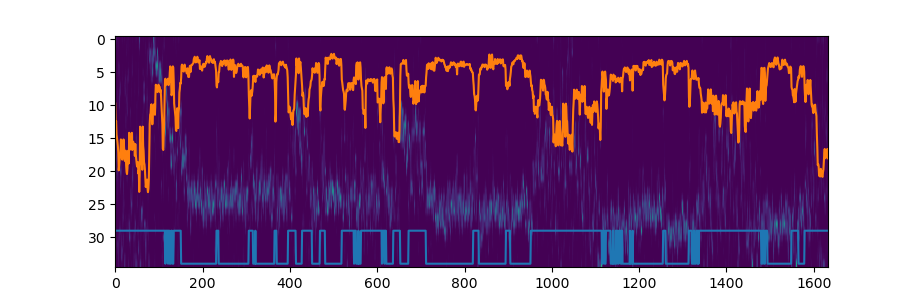

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
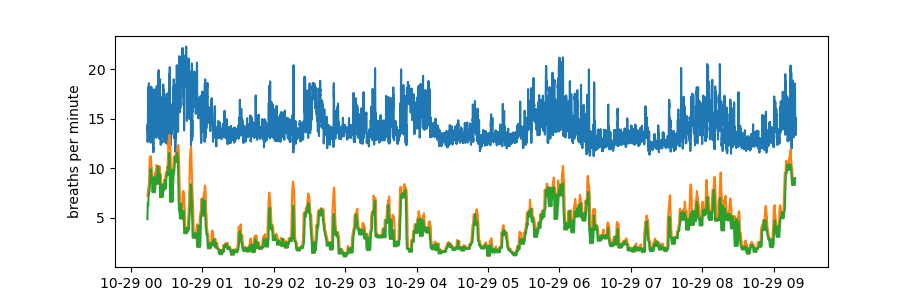

In [30]:
plt.close("all")
_, ax = plt.subplots(1, 1, figsize=(9.2, 3))
ax.imshow(rate_data_chunks, aspect="auto")
ax.plot(34.0 - (min_std > 3.0) * 5.0)
ax.plot(min_std * 2.0)
# ax.plot(all_std[sum_length // 2:-(sum_length // 2)] * 2.0)
plt.show()

_, ax = plt.subplots(1, 1, figsize=(9.2, 3))
# ax.plot(timestamps[:-61], av_freq * 60.0)
ax.plot(timestamps[:-61], alt_inst_rate * 60.0)
# ax.plot(timestamps[:-61], np.sqrt(alt_inst_var) * 60.0)
# ax.plot(timestamps[:-61], max_val * 20.0 + 3.5)
ax.plot(timestamps[:lgth:chunk_size], all_std[sum_length // 2:-(sum_length // 2)])
ax.plot(timestamps[:lgth:chunk_size], min_std)
# ax.plot(timestamps[:-61], (alt_inst_rate + alt_std) * 60.0)
# ax.plot(timestamps[:-61], (alt_inst_rate - alt_std) * 60.0)
ax.set_ylabel("breaths per minute")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
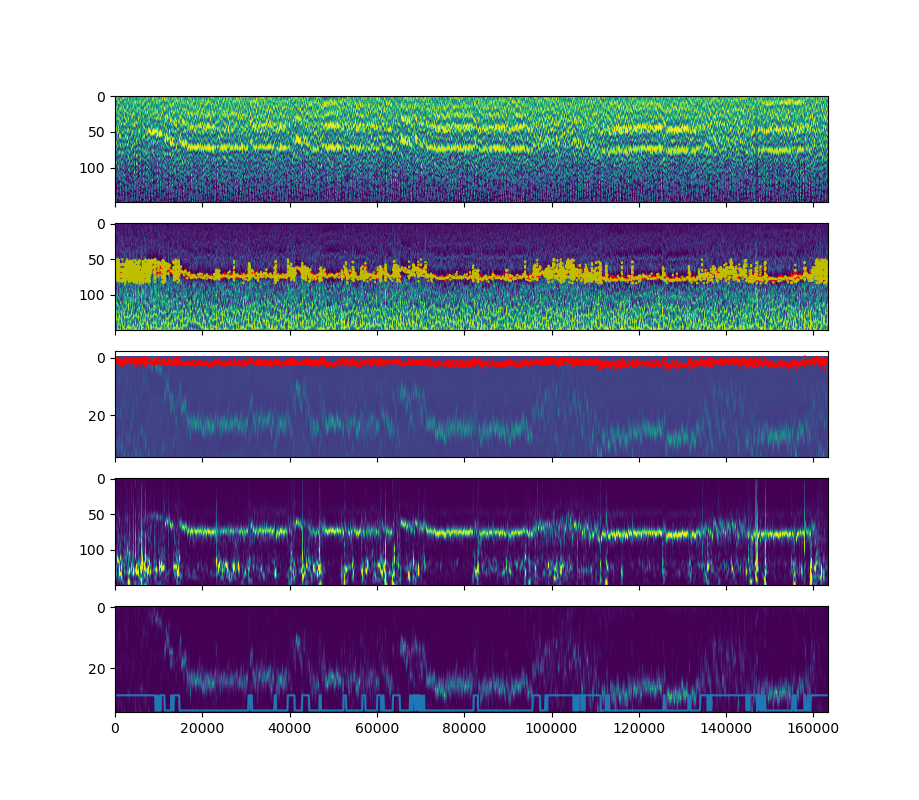

In [35]:

_, (ax1, ax2, ax5, ax3, ax4) = plt.subplots(5, 1, sharex=True, figsize=(9.2,8))
ax1.imshow((ddcol * scale).clip(0.0, 1.0), aspect="auto")
ax2.imshow(np.exp(-scale * np.abs(dcol)), aspect="auto")
ax5.imshow(some_shit[50:85].clip(min=-0.1, max=0.1), aspect="auto")
ax3.imshow(mags.clip(max=np.percentile(mags, 98.0)), aspect="auto")
ax4.imshow(rate_data.clip(max=0.05), aspect="auto")
ax2.plot(inst_rate, c="r", linestyle=":")
ax2.plot(max_arg + 50, c="y", linestyle=":")
ax5.plot(sum_some_shit * 20.0, c="r", linestyle=":")
# ax4.plot(inst_std, c="y", linestyle=":")
# ax4.plot((34.5 - rate_mag * 30.0).clip(0.0), c="c", linestyle=":")
# ax4.plot(np.arange(0, lgth, 100), 29.0 - np.tanh(0.5 * (all_std[sum_length // 2:-(sum_length // 2)] - 4)) * 5.0)
ax4.plot(np.arange(0, lgth, 100), 34.0 - (min_std > 4) * 5.0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
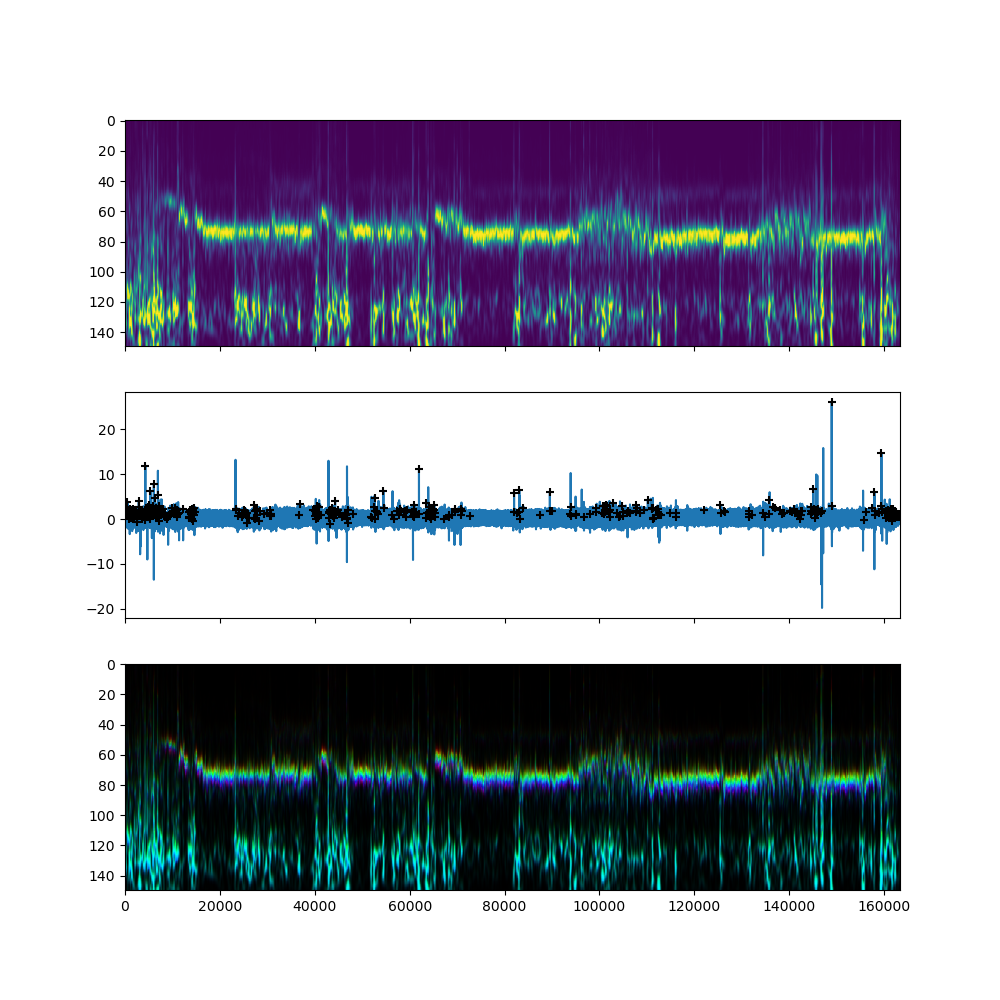

In [8]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax1.imshow(mags.clip(max=np.percentile(mags, 95.0)), aspect="auto")
ax2.plot(final_sm)
ax2.scatter(apneas, final_sm[apneas], c="k", marker="+", zorder=1000)
ax3.imshow(dcols, aspect="auto")
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
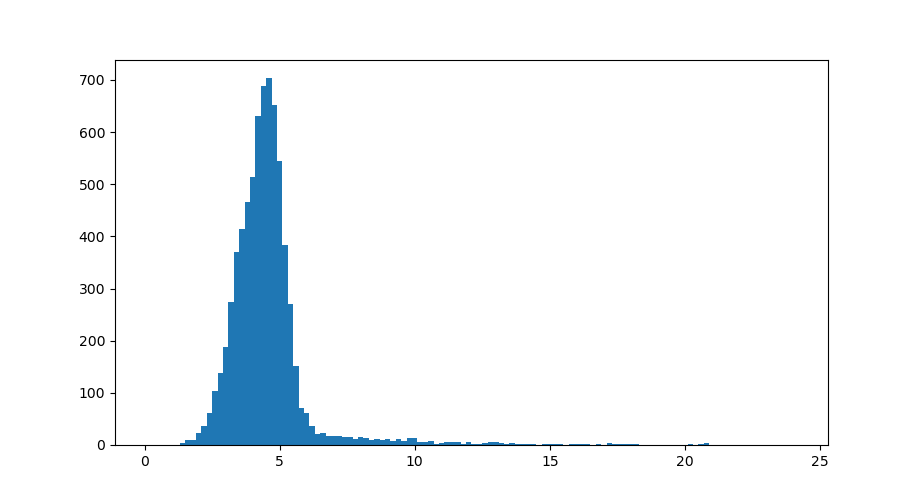

In [9]:
_, ax = plt.subplots(1, 1, figsize=(9.2, 5))
ax.hist(pk_dist * 0.2, bins=120, range=(0.1, 24.1))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
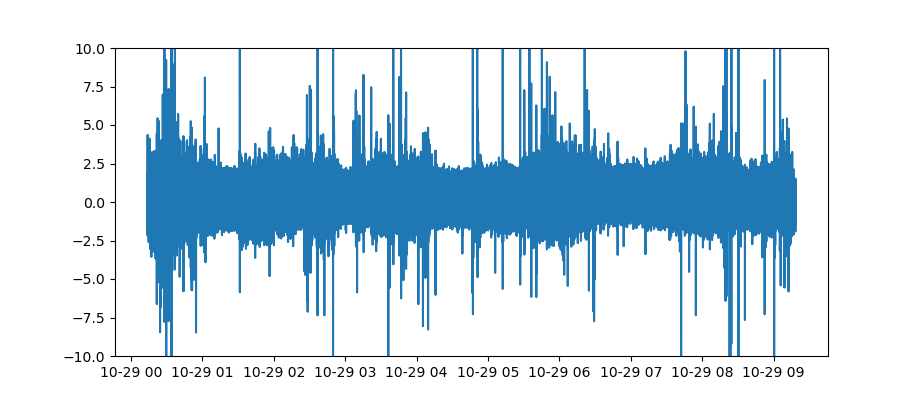

In [10]:
_, ax = plt.subplots(1, 1, figsize=(9.2, 4))
ax.plot(timestamps[:-60], final)
ax.set_ylim([-10, 10])
plt.show()